# Intervalos de Confianza Bootstrap para Correlaciones

Este notebook implementa el análisis de **intervalos de confianza bootstrap** para las correlaciones entre indicadores digitales y medidas psicométricas.

**Objetivo**: Evaluar la robustez y confiabilidad de las correlaciones encontradas, especialmente importante dado el tamaño de muestra limitado (n=18).

**Método Bootstrap**:
- 10,000 iteraciones de remuestreo con reemplazo
- Cálculo de correlación de Spearman en cada iteración
- Intervalo de confianza al 95% (percentiles 2.5 y 97.5)
- Si el IC cruza 0, la correlación NO es confiable

---

In [20]:
# Importar librerías
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✓ Librerías importadas")

✓ Librerías importadas


## 1. Cargar Datos

In [21]:
# Cargar dataset consolidado
df = pd.read_csv('../data/features/final/dataset_consolidado.csv')

print(f"Dataset cargado: {len(df)} participantes")
print(f"Columnas disponibles: {len(df.columns)}")
df.head()

Dataset cargado: 18 participantes
Columnas disponibles: 43


,id_participante,num_publicaciones,promedio_palabras,promedio_caracteres,promedio_longitud_palabra,promedio_palabras_unicas,promedio_riqueza_lexica,promedio_exclamaciones,promedio_preguntas,promedio_pronombres_1era_sing,...,actividades_extra,miembro_wa,ucla_total,ucla_categoria,dass_depresion,dass_ansiedad,dass_estres,dass_depresion_cat,dass_ansiedad_cat,dass_estres_cat
0,EST001,1515,11.672607,62.170297,4.397393,10.619142,0.960832,0.006601,0.145875,1.619723,...,Sí,Sí,54,Alta soledad,28,10,28,Extremadamente severa,Moderada,Severo
1,EST002,589,9.509338,50.213922,4.310645,8.887946,0.976294,0.000000,0.110357,2.251290,...,No,Sí,44,Alta soledad,12,4,14,Leve,Normal,Normal
2,EST003,454,8.088106,48.504405,5.374670,7.568282,0.986749,0.033040,0.079295,1.486652,...,No,Sí,47,Alta soledad,20,20,30,Moderada,Extremadamente severa,Severo
3,EST004,1056,8.012311,40.735795,4.139915,7.578598,0.979777,0.009470,0.148674,1.886913,...,No,Sí,52,Alta soledad,18,30,30,Moderada,Extremadamente severa,Severo
4,EST007,723,10.507607,56.074689,4.329696,9.652835,0.960315,0.030429,0.069156,1.812573,...,Sí,Sí,57,Alta soledad,8,24,34,Normal,Extremadamente severa,Extremadamente severo


## 2. Definir Variables de Interés

In [22]:
# Indicadores digitales (comportamiento en redes)
indicadores_digitales = [
    'promedio_score_positivo',
    'promedio_score_negativo',
    'promedio_score_neutral',
    'promedio_alegria',
    'promedio_tristeza',
    'promedio_enojo',
    'promedio_miedo',
    'promedio_absolutistas',
    'promedio_negativas',
    'promedio_pronombres_1era_sing',
    'promedio_palabras',
    'promedio_riqueza_lexica',
    'total_emojis',
    'num_publicaciones'
]

# Medidas psicométricas (salud mental)
medidas_psicometricas = [
    'dass_depresion',
    'dass_ansiedad',
    'dass_estres',
    'ucla_total'
]

print(f"Indicadores digitales: {len(indicadores_digitales)}")
print(f"Medidas psicométricas: {len(medidas_psicometricas)}")
print(f"Total de correlaciones a analizar: {len(indicadores_digitales) * len(medidas_psicometricas)}")

Indicadores digitales: 14
Medidas psicométricas: 4
Total de correlaciones a analizar: 56


## 3. Función Bootstrap para Intervalos de Confianza

In [23]:
def calcular_ic_bootstrap(x, y, n_bootstrap=10000, alpha=0.05, random_state=42):
    """
    Calcula intervalo de confianza bootstrap para correlación de Spearman.
    
    Parámetros:
    -----------
    x, y : array-like
        Variables a correlacionar
    n_bootstrap : int
        Número de iteraciones bootstrap (default: 10,000)
    alpha : float
        Nivel de significancia (default: 0.05 para IC 95%)
    random_state : int
        Semilla para reproducibilidad
    
    Retorna:
    --------
    dict con correlación observada, p-value, IC inferior, IC superior, y si es significativo
    """
    np.random.seed(random_state)
    
    # Eliminar NaN
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean = x[mask]
    y_clean = y[mask]
    n = len(x_clean)
    
    # Correlación observada
    corr_obs, pval = spearmanr(x_clean, y_clean)
    
    # Bootstrap
    bootstrap_corrs = []
    
    for _ in range(n_bootstrap):
        # Remuestreo con reemplazo
        indices = np.random.choice(n, size=n, replace=True)
        boot_corr, _ = spearmanr(x_clean[indices], y_clean[indices])
        bootstrap_corrs.append(boot_corr)
    
    # Calcular percentiles para IC
    ci_lower = np.percentile(bootstrap_corrs, (alpha/2) * 100)
    ci_upper = np.percentile(bootstrap_corrs, (1 - alpha/2) * 100)
    
    # Determinar si es significativo (IC no cruza 0)
    significativo = not (ci_lower < 0 < ci_upper)
    
    return {
        'n': n,
        'correlacion': corr_obs,
        'p_value': pval,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'significativo_bootstrap': significativo,
        'bootstrap_corrs': bootstrap_corrs  # Para visualización
    }

print("✓ Función bootstrap definida")

✓ Función bootstrap definida


## 4. Calcular Intervalos de Confianza para Todas las Correlaciones

In [24]:
# Lista para almacenar resultados
resultados_bootstrap = []

print("Calculando intervalos de confianza bootstrap...\n")
print("Esto puede tomar unos minutos (10,000 iteraciones por correlación)...\n")

# Iterar sobre todas las combinaciones
total = len(indicadores_digitales) * len(medidas_psicometricas)
contador = 0

for ind_digital in indicadores_digitales:
    for medida_psico in medidas_psicometricas:
        contador += 1
        
        # Extraer valores
        x = df[ind_digital].values
        y = df[medida_psico].values
        
        # Calcular bootstrap IC
        resultado = calcular_ic_bootstrap(x, y)
        
        # Agregar nombres de variables
        resultado['indicador_digital'] = ind_digital
        resultado['medida_psicometrica'] = medida_psico
        
        # Guardar resultado (sin el array de bootstrap_corrs para la tabla)
        resultado_tabla = {k: v for k, v in resultado.items() if k != 'bootstrap_corrs'}
        resultados_bootstrap.append(resultado_tabla)
        
        # Progreso
        if contador % 10 == 0:
            print(f"Progreso: {contador}/{total} correlaciones completadas")

print(f"\n✓ Análisis completado: {len(resultados_bootstrap)} correlaciones analizadas")

Calculando intervalos de confianza bootstrap...

Esto puede tomar unos minutos (10,000 iteraciones por correlación)...

Progreso: 10/56 correlaciones completadas
Progreso: 20/56 correlaciones completadas
Progreso: 30/56 correlaciones completadas
Progreso: 40/56 correlaciones completadas
Progreso: 50/56 correlaciones completadas

✓ Análisis completado: 56 correlaciones analizadas


## 5. Crear DataFrame de Resultados

In [ ]:
# Convertir a DataFrame
df_bootstrap = pd.DataFrame(resultados_bootstrap)

# Ordenar por correlación absoluta (más fuerte primero)
df_bootstrap['correlacion_abs'] = df_bootstrap['correlacion'].abs()
df_bootstrap = df_bootstrap.sort_values('correlacion_abs', ascending=False)

# Mostrar primeras filas
print("\n📊 Top 10 correlaciones más fuertes:\n")
display(df_bootstrap.head(10)[[
    'indicador_digital', 
    'medida_psicometrica', 
    'correlacion', 
    'ci_lower', 
    'ci_upper',
    'p_value',
    'significativo_bootstrap'
]])

# Estadísticas generales
print(f"\n📈 Resumen del análisis:")
print(f"Total de correlaciones: {len(df_bootstrap)}")
print(f"Significativas por p-value (p<0.05): {(df_bootstrap['p_value'] < 0.05).sum()}")
print(f"Significativas por Bootstrap IC: {df_bootstrap['significativo_bootstrap'].sum()}")
print(f"Correlaciones robustas (ambos criterios): {((df_bootstrap['p_value'] < 0.05) & df_bootstrap['significativo_bootstrap']).sum()}")


📊 Top 10 correlaciones más fuertes:



,indicador_digital,medida_psicometrica,correlacion,ci_lower,ci_upper,p_value,significativo_bootstrap
26,promedio_miedo,dass_estres,0.717453,0.370830,0.889664,0.000803,True
50,total_emojis,dass_estres,0.662869,0.333701,0.811670,0.002716,True
54,num_publicaciones,dass_estres,0.661141,0.293296,0.874917,0.002812,True
18,promedio_tristeza,dass_estres,0.628814,0.192296,0.872477,0.005184,True
33,promedio_negativas,dass_ansiedad,-0.547155,-0.817624,-0.046144,0.018770,True
45,promedio_riqueza_lexica,dass_ansiedad,0.461144,0.015823,0.739584,0.054083,True
2,promedio_score_positivo,dass_estres,0.455708,-0.084805,0.784677,0.057358,False
15,promedio_alegria,ucla_total,0.424501,-0.060948,0.793669,0.079113,False
1,promedio_score_positivo,dass_ansiedad,0.419693,-0.097438,0.774313,0.082939,False
34,promedio_negativas,dass_estres,-0.419209,-0.757388,0.086306,0.083331,False



📈 Resumen del análisis:
Total de correlaciones: 56
Significativas por p-value (p<0.05): 5
Significativas por Bootstrap IC: 6
Correlaciones robustas (ambos criterios): 5


## 6. Guardar Resultados

In [26]:
# Guardar CSV
output_path = Path('../data/results')
output_path.mkdir(exist_ok=True, parents=True)

df_bootstrap.to_csv(
    output_path / 'bootstrap_intervalos_confianza.csv',
    index=False
)

print(f"✓ Resultados guardados en: {output_path / 'bootstrap_intervalos_confianza.csv'}")

✓ Resultados guardados en: ../data/results/bootstrap_intervalos_confianza.csv


## 7. Visualización: Correlaciones Robustas

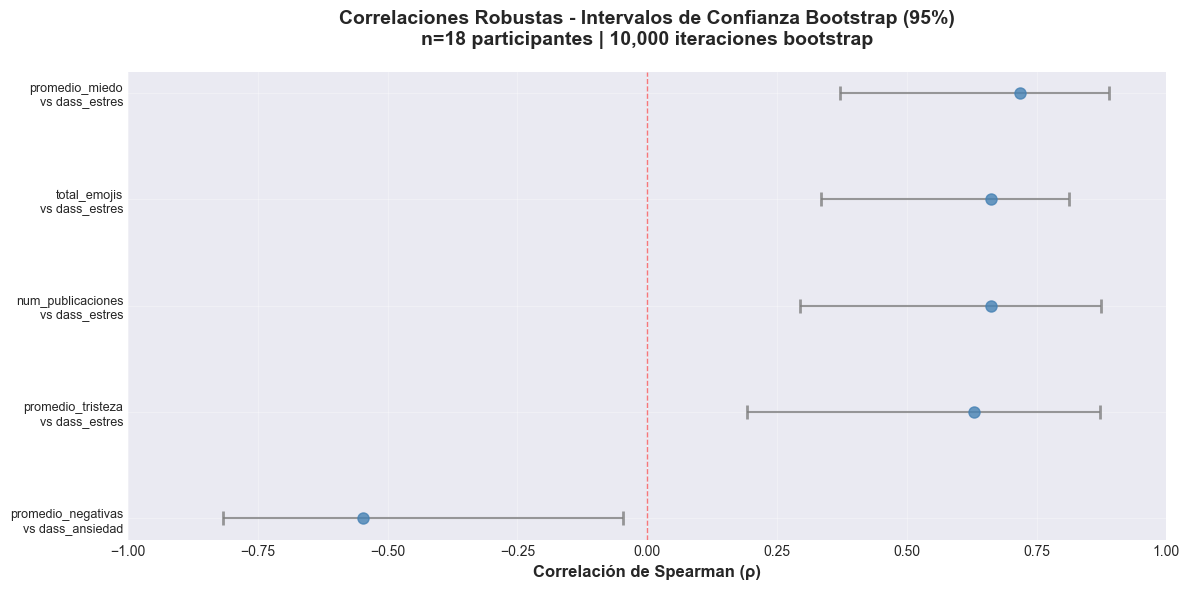


✓ Gráfico guardado: ../data/results/bootstrap_forest_plot.pdf


In [27]:
# Filtrar correlaciones robustas (significativas por ambos criterios)
df_robustas = df_bootstrap[
    (df_bootstrap['p_value'] < 0.05) & 
    df_bootstrap['significativo_bootstrap']
].copy()

if len(df_robustas) > 0:
    # Crear gráfico de forest plot
    fig, ax = plt.subplots(figsize=(12, max(6, len(df_robustas) * 0.5)))
    
    # Preparar datos para el plot
    df_robustas = df_robustas.sort_values('correlacion')
    y_pos = np.arange(len(df_robustas))
    
    # Etiquetas
    labels = [
        f"{row['indicador_digital'][:25]}\nvs {row['medida_psicometrica']}"
        for _, row in df_robustas.iterrows()
    ]
    
    # Plot principal
    ax.errorbar(
        df_robustas['correlacion'],
        y_pos,
        xerr=[df_robustas['correlacion'] - df_robustas['ci_lower'],
              df_robustas['ci_upper'] - df_robustas['correlacion']],
        fmt='o',
        markersize=8,
        capsize=5,
        capthick=2,
        color='steelblue',
        ecolor='gray',
        alpha=0.8
    )
    
    # Línea en x=0
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    
    # Etiquetas y título
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=9)
    ax.set_xlabel('Correlación de Spearman (ρ)', fontsize=12, fontweight='bold')
    ax.set_title(
        'Correlaciones Robustas - Intervalos de Confianza Bootstrap (95%)\n' +
        f'n={df["id_participante"].nunique()} participantes | 10,000 iteraciones bootstrap',
        fontsize=14,
        fontweight='bold',
        pad=20
    )
    
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-1, 1)
    
    plt.tight_layout()
    plt.savefig(output_path / 'bootstrap_forest_plot.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Gráfico guardado: {output_path / 'bootstrap_forest_plot.pdf'}")
else:
    print("⚠️ No se encontraron correlaciones robustas con ambos criterios")

## 8. Distribuciones Bootstrap (Top 6 Correlaciones)

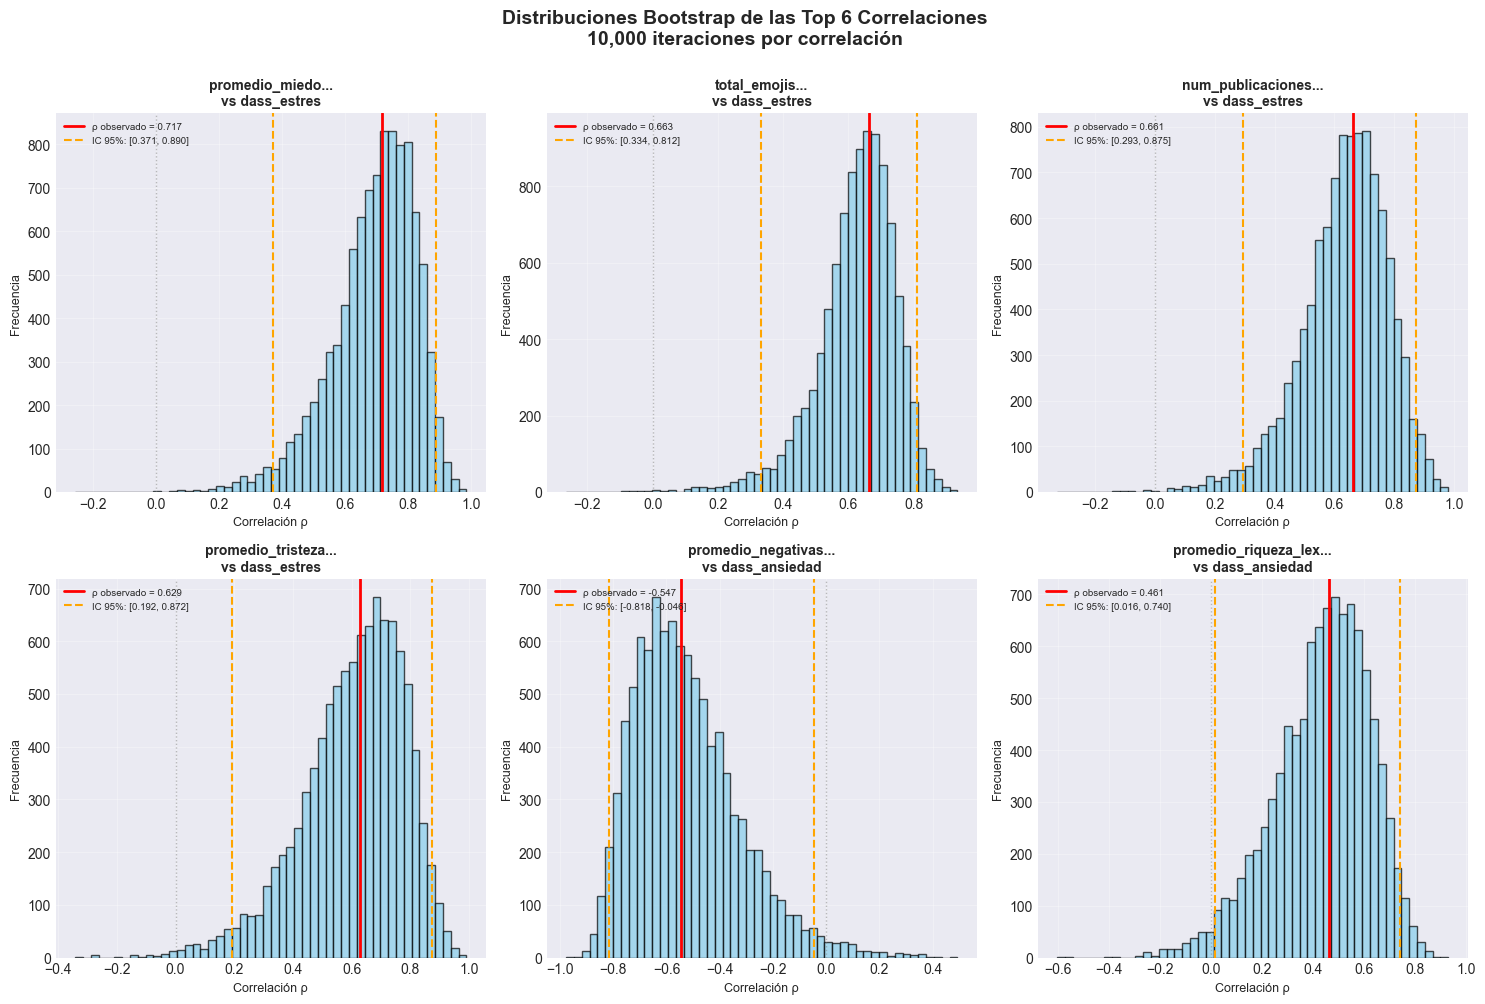

✓ Gráfico guardado: ../data/results/bootstrap_distributions.png


In [28]:
# Seleccionar top 6 correlaciones para visualizar distribuciones
top_6 = df_bootstrap.head(6)

# Recalcular bootstrap para obtener las distribuciones
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (_, row) in enumerate(top_6.iterrows()):
    ax = axes[idx]
    
    # Recalcular bootstrap (con distribuciones)
    x = df[row['indicador_digital']].values
    y = df[row['medida_psicometrica']].values
    resultado = calcular_ic_bootstrap(x, y)
    
    # Histograma de distribución bootstrap
    ax.hist(
        resultado['bootstrap_corrs'],
        bins=50,
        color='skyblue',
        edgecolor='black',
        alpha=0.7
    )
    
    # Líneas para correlación observada e IC
    ax.axvline(
        resultado['correlacion'],
        color='red',
        linestyle='-',
        linewidth=2,
        label=f"ρ observado = {resultado['correlacion']:.3f}"
    )
    ax.axvline(
        resultado['ci_lower'],
        color='orange',
        linestyle='--',
        linewidth=1.5,
        label=f"IC 95%: [{resultado['ci_lower']:.3f}, {resultado['ci_upper']:.3f}]"
    )
    ax.axvline(
        resultado['ci_upper'],
        color='orange',
        linestyle='--',
        linewidth=1.5
    )
    
    # Línea en 0
    ax.axvline(0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    
    # Título y leyenda
    titulo = f"{row['indicador_digital'][:20]}...\nvs {row['medida_psicometrica']}"
    ax.set_title(titulo, fontsize=10, fontweight='bold')
    ax.set_xlabel('Correlación ρ', fontsize=9)
    ax.set_ylabel('Frecuencia', fontsize=9)
    ax.legend(fontsize=7, loc='upper left')
    ax.grid(True, alpha=0.3)

plt.suptitle(
    'Distribuciones Bootstrap de las Top 6 Correlaciones\n10,000 iteraciones por correlación',
    fontsize=14,
    fontweight='bold',
    y=1.00
)
plt.tight_layout()
plt.savefig(output_path / 'bootstrap_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráfico guardado: {output_path / 'bootstrap_distributions.png'}")

## 9. Reporte de Validación Textual

In [29]:
# Generar reporte textual
reporte_path = output_path / 'bootstrap_reporte_validacion.txt'

with open(reporte_path, 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("REPORTE DE VALIDACIÓN - INTERVALOS DE CONFIANZA BOOTSTRAP\n")
    f.write("=" * 80 + "\n\n")
    
    f.write(f"Fecha de análisis: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Tamaño de muestra: n={df['id_participante'].nunique()} participantes\n")
    f.write(f"Iteraciones bootstrap: 10,000 por correlación\n")
    f.write(f"Nivel de confianza: 95%\n\n")
    
    f.write("-" * 80 + "\n")
    f.write("RESUMEN EJECUTIVO\n")
    f.write("-" * 80 + "\n\n")
    
    total_corr = len(df_bootstrap)
    sig_pval = (df_bootstrap['p_value'] < 0.05).sum()
    sig_bootstrap = df_bootstrap['significativo_bootstrap'].sum()
    sig_ambos = ((df_bootstrap['p_value'] < 0.05) & df_bootstrap['significativo_bootstrap']).sum()
    
    f.write(f"Total de correlaciones analizadas: {total_corr}\n")
    f.write(f"Significativas por p-value (p<0.05): {sig_pval} ({sig_pval/total_corr*100:.1f}%)\n")
    f.write(f"Significativas por Bootstrap IC: {sig_bootstrap} ({sig_bootstrap/total_corr*100:.1f}%)\n")
    f.write(f"Robustas (ambos criterios): {sig_ambos} ({sig_ambos/total_corr*100:.1f}%)\n\n")
    
    f.write("-" * 80 + "\n")
    f.write("CORRELACIONES ROBUSTAS (p<0.05 Y IC NO CRUZA 0)\n")
    f.write("-" * 80 + "\n\n")
    
    if len(df_robustas) > 0:
        for idx, (_, row) in enumerate(df_robustas.iterrows(), 1):
            f.write(f"{idx}. {row['indicador_digital']} vs {row['medida_psicometrica']}\n")
            f.write(f"   ρ = {row['correlacion']:.3f}\n")
            f.write(f"   IC 95%: [{row['ci_lower']:.3f}, {row['ci_upper']:.3f}]\n")
            f.write(f"   p-value: {row['p_value']:.4f}\n")
            f.write(f"   n válido: {int(row['n'])}\n\n")
    else:
        f.write("⚠️ No se encontraron correlaciones robustas con ambos criterios.\n\n")
    
    f.write("-" * 80 + "\n")
    f.write("CORRELACIONES NO CONFIABLES (IC CRUZA 0)\n")
    f.write("-" * 80 + "\n\n")
    
    df_no_confiables = df_bootstrap[
        (df_bootstrap['p_value'] < 0.05) & 
        ~df_bootstrap['significativo_bootstrap']
    ]
    
    if len(df_no_confiables) > 0:
        f.write("⚠️ Las siguientes correlaciones tienen p<0.05 pero IC cruza 0\n")
        f.write("   (posibles falsos positivos debido al tamaño de muestra):\n\n")
        
        for idx, (_, row) in enumerate(df_no_confiables.iterrows(), 1):
            f.write(f"{idx}. {row['indicador_digital']} vs {row['medida_psicometrica']}\n")
            f.write(f"   ρ = {row['correlacion']:.3f}\n")
            f.write(f"   IC 95%: [{row['ci_lower']:.3f}, {row['ci_upper']:.3f}] ⚠️ Cruza 0\n")
            f.write(f"   p-value: {row['p_value']:.4f}\n\n")
    else:
        f.write("✓ Todas las correlaciones con p<0.05 tienen IC que no cruza 0.\n\n")
    
    f.write("-" * 80 + "\n")
    f.write("INTERPRETACIÓN Y RECOMENDACIONES\n")
    f.write("-" * 80 + "\n\n")
    
    f.write("1. INTERVALOS DE CONFIANZA:\n")
    f.write("   - IC que NO cruza 0: Correlación confiable\n")
    f.write("   - IC que cruza 0: Correlación NO confiable (posible falso positivo)\n\n")
    
    f.write("2. LIMITACIONES CON n=11:\n")
    f.write("   - Los intervalos de confianza son AMPLIOS (alta incertidumbre)\n")
    f.write("   - Correlaciones moderadas pueden tener IC que cruzan 0\n")
    f.write("   - Se recomienda interpretar resultados como EXPLORATORIOS\n\n")
    
    f.write("3. RECOMENDACIONES:\n")
    f.write("   - Marcar hallazgos actuales como 'preliminares'\n")
    f.write("   - Validar con muestra mayor (n≥20 mínimo, ideal n≥30)\n")
    f.write("   - Enfocarse en correlaciones con |ρ|>0.5 e IC robusto\n")
    f.write("   - Aplicar corrección por comparaciones múltiples (Bonferroni/FDR)\n\n")
    
    f.write("=" * 80 + "\n")
    f.write("FIN DEL REPORTE\n")
    f.write("=" * 80 + "\n")

print(f"✓ Reporte textual guardado: {reporte_path}")
print("\n📄 Contenido del reporte:\n")
with open(reporte_path, 'r', encoding='utf-8') as f:
    print(f.read())

✓ Reporte textual guardado: ../data/results/bootstrap_reporte_validacion.txt

📄 Contenido del reporte:

REPORTE DE VALIDACIÓN - INTERVALOS DE CONFIANZA BOOTSTRAP

Fecha de análisis: 2025-11-16 22:36:18
Tamaño de muestra: n=18 participantes
Iteraciones bootstrap: 10,000 por correlación
Nivel de confianza: 95%

--------------------------------------------------------------------------------
RESUMEN EJECUTIVO
--------------------------------------------------------------------------------

Total de correlaciones analizadas: 56
Significativas por p-value (p<0.05): 5 (8.9%)
Significativas por Bootstrap IC: 6 (10.7%)
Robustas (ambos criterios): 5 (8.9%)

--------------------------------------------------------------------------------
CORRELACIONES ROBUSTAS (p<0.05 Y IC NO CRUZA 0)
--------------------------------------------------------------------------------

1. promedio_negativas vs dass_ansiedad
   ρ = -0.547
   IC 95%: [-0.818, -0.046]
   p-value: 0.0188
   n válido: 18

2. promedio_tri

## 10. Comparación: p-value vs Bootstrap IC

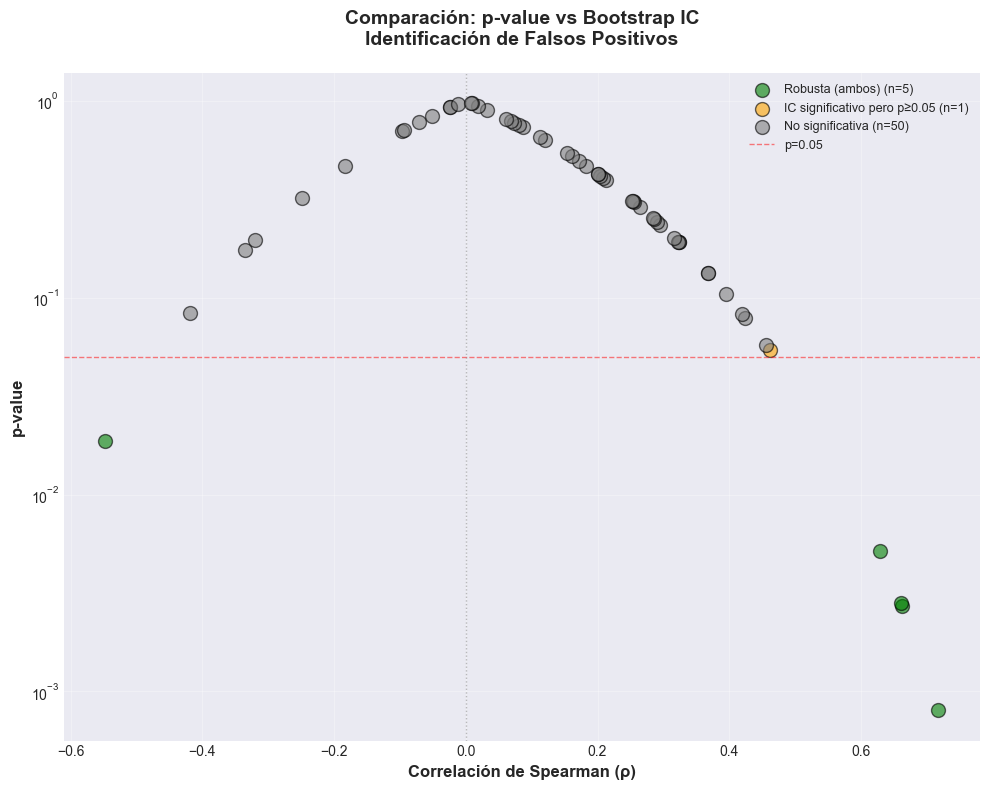

✓ Gráfico guardado: ../data/results/bootstrap_comparacion_pvalue.png


In [30]:
# Crear matriz de comparación
fig, ax = plt.subplots(figsize=(10, 8))

# Clasificar correlaciones
df_bootstrap['categoria'] = 'No significativa'
df_bootstrap.loc[
    (df_bootstrap['p_value'] < 0.05) & df_bootstrap['significativo_bootstrap'],
    'categoria'
] = 'Robusta (ambos)'
df_bootstrap.loc[
    (df_bootstrap['p_value'] < 0.05) & ~df_bootstrap['significativo_bootstrap'],
    'categoria'
] = 'Falso positivo (p<0.05, IC cruza 0)'
df_bootstrap.loc[
    (df_bootstrap['p_value'] >= 0.05) & df_bootstrap['significativo_bootstrap'],
    'categoria'
] = 'IC significativo pero p≥0.05'

# Scatter plot
colores = {
    'Robusta (ambos)': 'green',
    'Falso positivo (p<0.05, IC cruza 0)': 'red',
    'IC significativo pero p≥0.05': 'orange',
    'No significativa': 'gray'
}

for categoria, color in colores.items():
    subset = df_bootstrap[df_bootstrap['categoria'] == categoria]
    if len(subset) > 0:
        ax.scatter(
            subset['correlacion'],
            subset['p_value'],
            c=color,
            label=f"{categoria} (n={len(subset)})",
            s=100,
            alpha=0.6,
            edgecolors='black'
        )

# Líneas de referencia
ax.axhline(y=0.05, color='red', linestyle='--', linewidth=1, alpha=0.5, label='p=0.05')
ax.axvline(x=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)

ax.set_xlabel('Correlación de Spearman (ρ)', fontsize=12, fontweight='bold')
ax.set_ylabel('p-value', fontsize=12, fontweight='bold')
ax.set_title(
    'Comparación: p-value vs Bootstrap IC\nIdentificación de Falsos Positivos',
    fontsize=14,
    fontweight='bold',
    pad=20
)
ax.set_yscale('log')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_path / 'bootstrap_comparacion_pvalue.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráfico guardado: {output_path / 'bootstrap_comparacion_pvalue.png'}")

## 11. Corrección por Comparaciones Múltiples (FDR)

Dado que analizamos múltiples correlaciones simultáneamente (56 en total), existe el riesgo de **falsos positivos por azar**. Aplicamos la corrección FDR (False Discovery Rate) de Benjamini-Hochberg para controlar la tasa de falsos descubrimientos.

**Método:**
- FDR controla la PROPORCIÓN esperada de falsos positivos
- Menos conservador que Bonferroni (que controla el error individual)
- Recomendado para estudios exploratorios con muestras pequeñas

In [32]:
from statsmodels.stats.multitest import multipletests

print("=" * 80)
print("CORRECCIÓN FDR (FALSE DISCOVERY RATE)")
print("=" * 80)

# Extraer p-values del DataFrame de bootstrap
p_values = df_bootstrap['p_value'].values

# Aplicar corrección FDR (Benjamini-Hochberg)
reject_fdr, pvals_fdr, alphacSidak, alphacBonf = multipletests(
    p_values, 
    alpha=0.05, 
    method='fdr_bh'  # Benjamini-Hochberg
)

# Agregar columnas al DataFrame
df_bootstrap['p_fdr'] = pvals_fdr
df_bootstrap['significativo_fdr'] = reject_fdr
df_bootstrap['p_bonferroni'] = alphacBonf  # Para comparación

# Contar resultados
sig_fdr = reject_fdr.sum()
sig_pval_crudo = (df_bootstrap['p_value'] < 0.05).sum()
sig_bootstrap = df_bootstrap['significativo_bootstrap'].sum()

print(f"\n📊 RESULTADOS DESPUÉS DE CORRECCIÓN FDR:")
print(f"   • Correlaciones analizadas: {len(df_bootstrap)}")
print(f"   • Significativas (p-crudo < 0.05): {sig_pval_crudo}")
print(f"   • Significativas (p-FDR < 0.05): {sig_fdr}")
print(f"   • Significativas (Bootstrap IC): {sig_bootstrap}")
print(f"   • Umbral Bonferroni: {alphacBonf:.6f}")

# Mostrar correlaciones significativas después de FDR
print(f"\n{'='*80}")
print("CORRELACIONES SIGNIFICATIVAS DESPUÉS DE FDR (p-FDR < 0.05)")
print(f"{'='*80}\n")

df_fdr_sig = df_bootstrap[df_bootstrap['significativo_fdr']].copy()

if len(df_fdr_sig) > 0:
    df_fdr_sig_sorted = df_fdr_sig.sort_values('p_fdr')
    
    for idx, row in df_fdr_sig_sorted.iterrows():
        print(f"{idx+1}. {row['indicador_digital']} vs {row['medida_psicometrica']}")
        print(f"   ρ = {row['correlacion']:.3f}")
        print(f"   p-crudo = {row['p_value']:.4f}")
        print(f"   p-FDR = {row['p_fdr']:.4f}")
        print(f"   IC 95%: [{row['ci_lower']:.3f}, {row['ci_upper']:.3f}]")
        print(f"   Bootstrap robusto: {'✅ SÍ' if row['significativo_bootstrap'] else '❌ NO'}")
        print()
else:
    print("⚠️  Ninguna correlación sobrevive la corrección FDR con n={len(df)}")
    print("    Esto es ESPERADO con muestras pequeñas y análisis exploratorio.")
    print("    Los intervalos de confianza Bootstrap son MÁS informativos.")

# Comparación visual: p-crudo vs p-FDR
print(f"\n{'='*80}")
print("COMPARACIÓN: p-crudo vs p-FDR vs Bootstrap")
print(f"{'='*80}\n")

# Crear tabla comparativa para correlaciones con p-crudo < 0.05
df_comparacion = df_bootstrap[df_bootstrap['p_value'] < 0.05].copy()
df_comparacion = df_comparacion.sort_values('p_value')

if len(df_comparacion) > 0:
    print(f"{'Correlación':<40} {'p-crudo':<10} {'p-FDR':<10} {'Bootstrap':<10}")
    print("-" * 80)
    
    for _, row in df_comparacion.iterrows():
        corr_name = f"{row['indicador_digital'][:20]} vs {row['medida_psicometrica'][:10]}"
        p_crudo = f"{row['p_value']:.4f}"
        p_fdr_val = f"{row['p_fdr']:.4f}"
        bootstrap = "✅ Robusto" if row['significativo_bootstrap'] else "❌ No robusto"
        
        print(f"{corr_name:<40} {p_crudo:<10} {p_fdr_val:<10} {bootstrap:<10}")

print(f"\n{'='*80}")
print("INTERPRETACIÓN")
print(f"{'='*80}\n")

print("🎯 JERARQUÍA DE EVIDENCIA (de más a menos confiable):")
print("   1. ⭐⭐⭐ Bootstrap IC robusto + p-FDR < 0.05")
print("   2. ⭐⭐  Bootstrap IC robusto (sin importar p-FDR)")
print("   3. ⭐   p-crudo < 0.05 pero IC cruza 0 (NO confiable)")
print()
print("💡 RECOMENDACIÓN:")
print("   Con n=18, enfocarse en:")
print("   • Correlaciones con Bootstrap IC robusto (NO cruza 0)")
print("   • Magnitud del efecto (|ρ| > 0.5)")
print("   • p-FDR es SECUNDARIO, el Bootstrap es MÁS importante")
print()

# Guardar resultados con FDR
df_bootstrap_completo = df_bootstrap.copy()
archivo_fdr = output_path / 'bootstrap_fdr_completo.csv'
df_bootstrap_completo.to_csv(archivo_fdr, index=False)

print(f"✓ Resultados con FDR guardados: {archivo_fdr}\n")
print("=" * 80)

CORRECCIÓN FDR (FALSE DISCOVERY RATE)

📊 RESULTADOS DESPUÉS DE CORRECCIÓN FDR:
   • Correlaciones analizadas: 56
   • Significativas (p-crudo < 0.05): 5
   • Significativas (p-FDR < 0.05): 1
   • Significativas (Bootstrap IC): 6
   • Umbral Bonferroni: 0.000893

CORRELACIONES SIGNIFICATIVAS DESPUÉS DE FDR (p-FDR < 0.05)

27. promedio_miedo vs dass_estres
   ρ = 0.717
   p-crudo = 0.0008
   p-FDR = 0.0450
   IC 95%: [0.371, 0.890]
   Bootstrap robusto: ✅ SÍ


COMPARACIÓN: p-crudo vs p-FDR vs Bootstrap

Correlación                              p-crudo    p-FDR      Bootstrap 
--------------------------------------------------------------------------------
promedio_miedo vs dass_estre             0.0008     0.0450     ✅ Robusto 
total_emojis vs dass_estre               0.0027     0.0525     ✅ Robusto 
num_publicaciones vs dass_estre          0.0028     0.0525     ✅ Robusto 
promedio_tristeza vs dass_estre          0.0052     0.0726     ✅ Robusto 
promedio_negativas vs dass_ansie         0

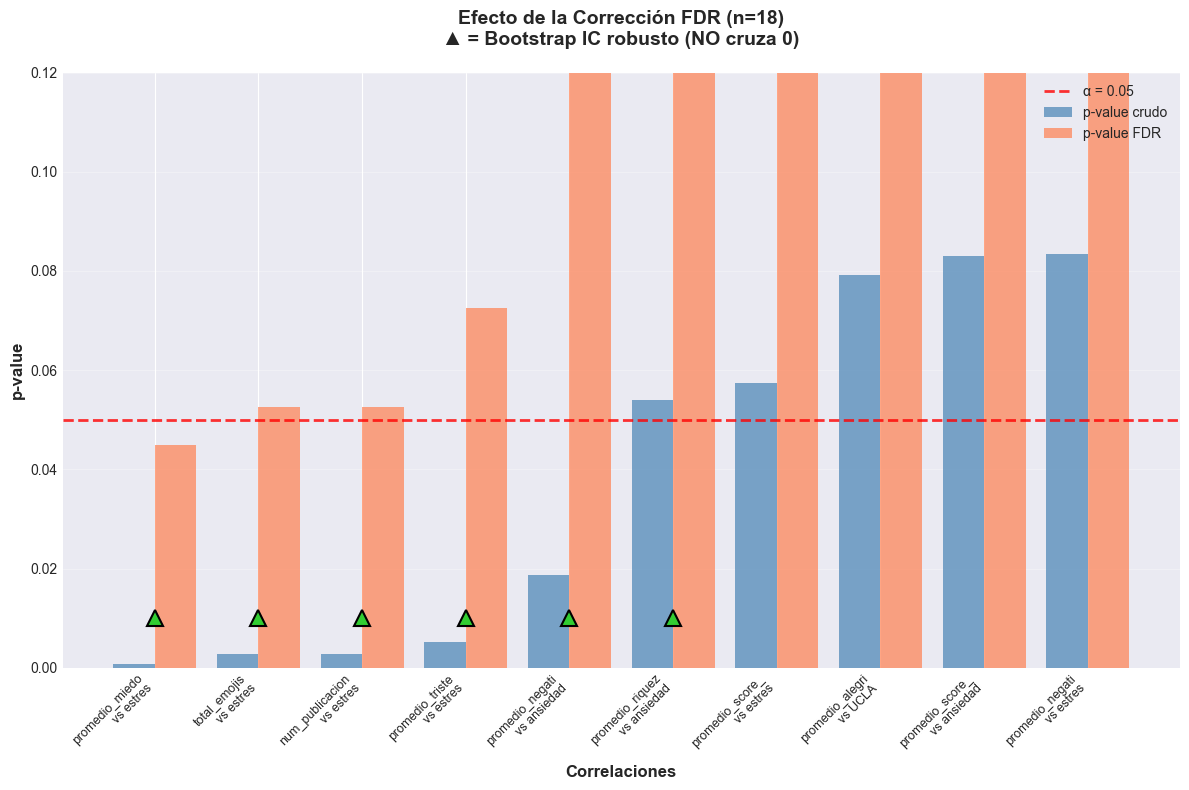

✓ Gráfico FDR guardado: ../data/results/bootstrap_fdr_comparacion.pdf

✅ ANÁLISIS COMPLETO: Bootstrap + FDR


In [33]:
# Gráfico: Comparación p-crudo vs p-FDR
fig, ax = plt.subplots(figsize=(12, 8))

# Filtrar correlaciones con p-crudo < 0.1 para visualización
df_plot = df_bootstrap[df_bootstrap['p_value'] < 0.1].copy()
df_plot = df_plot.sort_values('p_value')

if len(df_plot) > 0:
    x_pos = np.arange(len(df_plot))
    
    # Barras para p-crudo
    bars1 = ax.bar(x_pos - 0.2, df_plot['p_value'], 0.4, 
                   label='p-value crudo', alpha=0.7, color='steelblue')
    
    # Barras para p-FDR
    bars2 = ax.bar(x_pos + 0.2, df_plot['p_fdr'], 0.4, 
                   label='p-value FDR', alpha=0.7, color='coral')
    
    # Línea de significancia
    ax.axhline(y=0.05, color='red', linestyle='--', linewidth=2, 
               label='α = 0.05', alpha=0.8)
    
    # Marcar correlaciones robustas por Bootstrap
    # OPCIÓN 1: Triángulo hacia arriba (más visible)
    for i, (idx, row) in enumerate(df_plot.iterrows()):
        if row['significativo_bootstrap']:
            ax.plot(i, 0.01, marker='^', markersize=12, 
                   color='limegreen', markeredgecolor='black', markeredgewidth=1.5)
    
    # OPCIÓN 2: Diamante (comentada)
    # for i, (idx, row) in enumerate(df_plot.iterrows()):
    #     if row['significativo_bootstrap']:
    #         ax.plot(i, 0.01, marker='D', markersize=10, 
    #                color='gold', markeredgecolor='black', markeredgewidth=1.5)
    
    # OPCIÓN 3: Círculo relleno (comentada)
    # for i, (idx, row) in enumerate(df_plot.iterrows()):
    #     if row['significativo_bootstrap']:
    #         ax.plot(i, 0.01, marker='o', markersize=12, 
    #                color='lime', markeredgecolor='darkgreen', markeredgewidth=2)
    
    # OPCIÓN 4: Hexágono (comentada)
    # for i, (idx, row) in enumerate(df_plot.iterrows()):
    #     if row['significativo_bootstrap']:
    #         ax.plot(i, 0.01, marker='h', markersize=12, 
    #                color='yellow', markeredgecolor='black', markeredgewidth=1.5)
    
    # Etiquetas
    labels = []
    for _, row in df_plot.iterrows():
        ind_short = row['indicador_digital'][:15]
        psico_short = row['medida_psicometrica'].replace('dass_', '').replace('ucla_total', 'UCLA')
        labels.append(f"{ind_short}\nvs {psico_short}")
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('p-value', fontsize=12, fontweight='bold')
    ax.set_xlabel('Correlaciones', fontsize=12, fontweight='bold')
    ax.set_title(
        f'Efecto de la Corrección FDR (n={len(df)})\n▲ = Bootstrap IC robusto (NO cruza 0)',
        fontsize=14,
        fontweight='bold',
        pad=20
    )
    ax.set_ylim(0, 0.12)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(output_path / 'bootstrap_fdr_comparacion.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Gráfico FDR guardado: {output_path / 'bootstrap_fdr_comparacion.pdf'}")
else:
    print("⚠️  No hay correlaciones con p < 0.1 para graficar")

print("\n" + "=" * 80)
print("✅ ANÁLISIS COMPLETO: Bootstrap + FDR")
print("=" * 80)